In [1]:
%pip install yfinance finta

Note: you may need to restart the kernel to use updated packages.


In [12]:
import yfinance as yf
import pandas as pd
import numpy as np
from finta import TA
from tickerData import *
from mlAlgorithms import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = getTickerData(ticker="btc-usd", period="max", interval="1d")
df.drop(columns={'Volume', 'Adj Close'}, inplace=True)
df.rename(columns={'Date':'date', 'Open':'open', 'High':'high','Low':'low', 'Close':'close'}, inplace=True)
df

[*********************100%***********************]  1 of 1 completed


,date,open,high,low,close
0,2014-09-17,465.864014,468.174011,452.421997,457.334015
1,2014-09-18,456.859985,456.859985,413.104004,424.440002
2,2014-09-19,424.102997,427.834991,384.532013,394.795990
3,2014-09-20,394.673004,423.295990,389.882996,408.903992
4,2014-09-21,408.084991,412.425995,393.181000,398.821014
...,...,...,...,...,...
3089,2023-03-03,23476.632812,23479.347656,22213.238281,22362.679688
3090,2023-03-04,22362.923828,22405.177734,22198.980469,22353.349609
3091,2023-03-05,22354.144531,22613.685547,22307.142578,22435.513672
3092,2023-03-06,22436.816406,22584.292969,22331.314453,22429.757812


In [4]:
indicators = ['SMA', 'EMA', 'HMA', 'RSI', 'MACD', 'BBANDS']
df = getTickerIndicatorData(df, indicators)
df

,date,open,high,low,close,41 period SMA,9 period EMA,16 period HMA.,14 period RSI,MACD,SIGNAL,BB_UPPER,BB_MIDDLE,BB_LOWER
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,NaN,457.334015,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,NaN,439.059564,NaN,0.000000,-0.738007,-0.410004,NaN,NaN,NaN
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,NaN,420.918755,NaN,0.000000,-1.859626,-1.004111,NaN,NaN,NaN
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,NaN,416.848713,NaN,20.155072,-1.814822,-1.278742,NaN,NaN,NaN
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,NaN,411.485880,NaN,17.448333,-2.153494,-1.538961,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3089,2023-03-03,23476.632812,23479.347656,22213.238281,22362.679688,23227.257431,23313.757906,23051.605813,42.735439,161.802057,367.894964,25382.564541,23538.721094,21694.877647
3090,2023-03-04,22362.923828,22405.177734,22198.980469,22353.349609,23218.304592,23121.676247,22869.076891,42.664978,68.482518,308.012475,25312.569947,23566.978418,21821.386888
3091,2023-03-05,22354.144531,22613.685547,22307.142578,22435.513672,23206.135861,22984.443732,22670.722499,43.547701,1.142890,246.638558,25229.658402,23598.349023,21967.039645
3092,2023-03-06,22436.816406,22584.292969,22331.314453,22429.757812,23201.094131,22873.506548,22483.784127,43.497180,-52.088259,186.893195,25205.263359,23608.796680,22012.330001


In [5]:
df.dropna(inplace=True)

In [6]:
df.isnull().sum()

date              0
open              0
high              0
low               0
close             0
41 period SMA     0
9 period EMA      0
16 period HMA.    0
14 period RSI     0
MACD              0
SIGNAL            0
BB_UPPER          0
BB_MIDDLE         0
BB_LOWER          0
dtype: int64

In [7]:
df2 = produce_prediction(df, 14)
df2

,date,open,high,low,close,41 period SMA,9 period EMA,16 period HMA.,14 period RSI,MACD,SIGNAL,BB_UPPER,BB_MIDDLE,BB_LOWER,pred
40,2014-10-27,354.777008,358.631989,349.808990,352.989014,380.788635,363.663991,353.468163,39.026158,-5.157967,-2.096673,407.323340,373.896951,340.470563,1.0
41,2014-10-28,353.214996,359.984009,352.678986,357.618011,378.356537,362.454692,349.317459,41.629699,-5.426438,-2.762683,407.000618,374.130852,341.261085,1.0
42,2014-10-29,357.088989,357.833008,335.342987,335.591003,376.189488,357.081589,344.547598,34.155922,-7.272277,-3.664663,409.625952,372.659102,335.692252,1.0
43,2014-10-30,335.709015,350.912994,335.071991,345.304993,374.982391,354.726141,341.069877,39.328954,-7.883579,-4.508492,410.516219,371.846251,333.176283,1.0
44,2014-10-31,345.009003,348.045013,337.141998,338.321014,373.260855,351.444973,338.193822,37.073754,-8.812961,-5.369423,411.960112,370.647351,329.334590,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3089,2023-03-03,23476.632812,23479.347656,22213.238281,22362.679688,23227.257431,23313.757906,23051.605813,42.735439,161.802057,367.894964,25382.564541,23538.721094,21694.877647,NaN
3090,2023-03-04,22362.923828,22405.177734,22198.980469,22353.349609,23218.304592,23121.676247,22869.076891,42.664978,68.482518,308.012475,25312.569947,23566.978418,21821.386888,NaN
3091,2023-03-05,22354.144531,22613.685547,22307.142578,22435.513672,23206.135861,22984.443732,22670.722499,43.547701,1.142890,246.638558,25229.658402,23598.349023,21967.039645,NaN
3092,2023-03-06,22436.816406,22584.292969,22331.314453,22429.757812,23201.094131,22873.506548,22483.784127,43.497180,-52.088259,186.893195,25205.263359,23608.796680,22012.330001,NaN


In [8]:
df.dropna(inplace=True)

In [9]:
df.drop(columns={'open', 'high', 'low'}, inplace=True)
df.isnull().sum()

date              0
close             0
41 period SMA     0
9 period EMA      0
16 period HMA.    0
14 period RSI     0
MACD              0
SIGNAL            0
BB_UPPER          0
BB_MIDDLE         0
BB_LOWER          0
pred              0
dtype: int64

In [17]:
features = StandardScaler().fit_transform(df[df.columns.difference(['pred', 'date'])])
target = df['pred']

X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.4, shuffle=False)
X_train.shape

(1824, 10)

{'n_neighbors': 23}
              precision    recall  f1-score   support

         0.0       0.50      0.91      0.65       560
         1.0       0.74      0.22      0.34       656

    accuracy                           0.54      1216
   macro avg       0.62      0.57      0.49      1216
weighted avg       0.63      0.54      0.48      1216



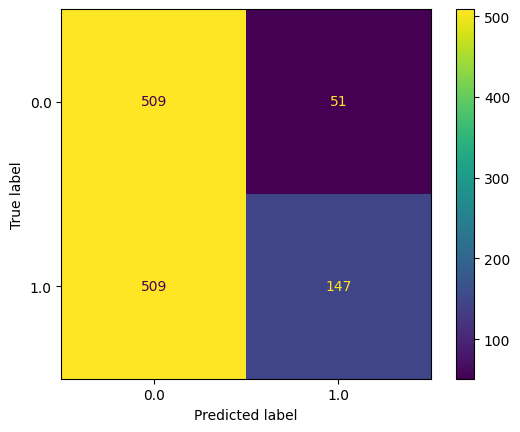

In [18]:
knn = trained_KNN(X_train, X_test, Y_train, Y_test)

In [20]:
metrics.accuracy_score(df['pred'], knn.predict(features))

0.6391447368421053